# Books Recommendation System

Problem Statements:
- Bagaimana membangun sistem rekomendasi yang dapat mempersonalisasi daftar bacaan pengguna berdasarkan preferensi eksplisit (rating) dan implisit (pola interaksi)?
- Bagaimana memanfaatkan metadata buku (judul, penulis, genre) untuk menghasilkan rekomendasi yang relevan secara konten?
- Bagaimana mengukur dan membandingkan performa antara model Collaborative Filtering (CF) dan Content-Based Filtering (CBF) dalam sistem rekomendasi buku?

## Import Library

In [1]:
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

## Data Collection

In [2]:
# Download Books.csv
gdown.download('https://drive.google.com/uc?id=1IrvVMbxdK_GIUGCVWMdKE_Ty23PqPBZP',
               'Books.csv', quiet=False)

# Download Ratings.csv
gdown.download('https://drive.google.com/uc?id=1gYAqXCFk2TA-nAg2bimXfYGkYn0v6Gy-',
               'Ratings.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IrvVMbxdK_GIUGCVWMdKE_Ty23PqPBZP
To: /content/Books.csv
100%|██████████| 73.3M/73.3M [00:01<00:00, 55.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gYAqXCFk2TA-nAg2bimXfYGkYn0v6Gy-
To: /content/Ratings.csv
100%|██████████| 22.6M/22.6M [00:00<00:00, 63.8MB/s]


'Ratings.csv'

In [3]:
# Baca file CSV
books = pd.read_csv('Books.csv', encoding='latin-1', low_memory=False)
ratings = pd.read_csv('Ratings.csv', encoding='latin-1')

In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Data Understanding

In [6]:
# Ukurat dataset
print(f"Books dataset shape: {books.shape}")
print(f"Ratings dataset shape: {ratings.shape}")

Books dataset shape: (271360, 8)
Ratings dataset shape: (1149780, 3)


### Univariate EDA (books)

In [7]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


keterangan: perlu diperiksa missing values semua kolom, konversi tahun publikasi ke int/datetime dan data non numerik, dan dropping variabel non relevan

In [9]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


keterangan: akan dilakukan imputasi nantinya karena variabel dianggap penting untuk CBF. nantinya NaN akan diubah menjadi string 'Unknown Author/Publisher'

In [10]:
print(f"Jumlah duplikat baris data: {books.duplicated().sum()}")

Jumlah duplikat baris data: 0


In [11]:
print(f"Jumlah duplikat ISBN: {books['ISBN'].duplicated().sum()}") # Primary key unik (no duplicate)

Jumlah duplikat ISBN: 0


In [12]:
# Cetak semua tahun terbit yang unik
unique_years = books['Year-Of-Publication'].unique()
print(unique_years)

['2002' '2001' '1991' '1999' '2000' '1993' '1996' '1988' '2004' '1998'
 '1994' '2003' '1997' '1983' '1979' '1995' '1982' '1985' '1992' '1986'
 '1978' '1980' '1952' '1987' '1990' '1981' '1989' '1984' '0' '1968' '1961'
 '1958' '1974' '1976' '1971' '1977' '1975' '1965' '1941' '1970' '1962'
 '1973' '1972' '1960' '1966' '1920' '1956' '1959' '1953' '1951' '1942'
 '1963' '1964' '1969' '1954' '1950' '1967' '2005' '1957' '1940' '1937'
 '1955' '1946' '1936' '1930' '2011' '1925' '1948' '1943' '1947' '1945'
 '1923' '2020' '1939' '1926' '1938' '2030' '1911' '1904' '1949' '1932'
 '1928' '1929' '1927' '1931' '1914' '2050' '1934' '1910' '1933' '1902'
 '1924' '1921' '1900' '2038' '2026' '1944' '1917' '1901' '2010' '1908'
 '1906' '1935' '1806' '2021' '2012' '2006' 'DK Publishing Inc' 'Gallimard'
 '1909' '2008' '1378' '1919' '1922' '1897' '2024' '1376' '2037']


keterangan: setelah diperiksa ternyata ada variabel non numerik (bukan tahun) di dalam variabel 'Year-of-Publication'. itu adalah data kotor yang mungkin saja terjadi karena ada salah ketik.

<ipython-input-13-89b76c93d23c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_authors.index, x=top_authors.values, palette='crest')


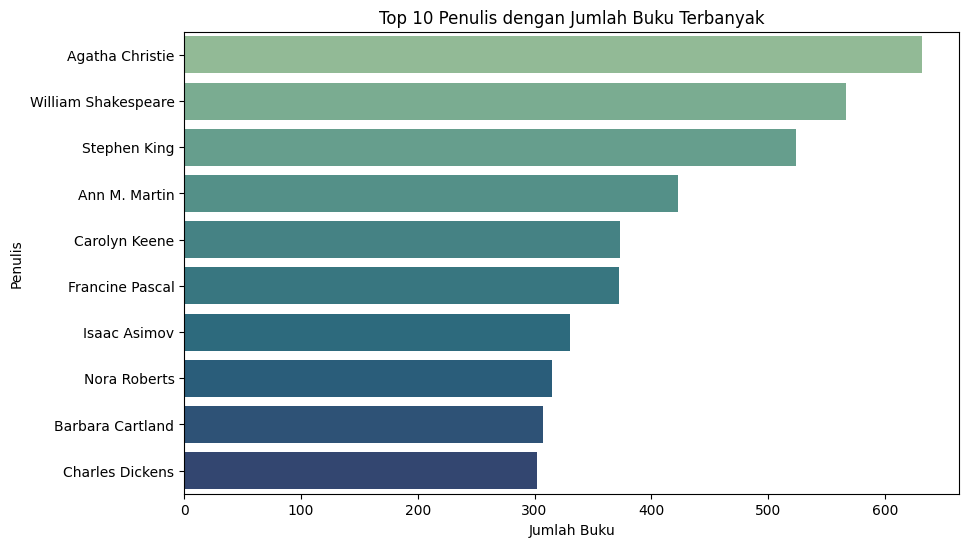

In [13]:
# Top 10 penulis dengan buku terbanyak
top_authors = books['Book-Author'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_authors.index, x=top_authors.values, palette='crest')
plt.title('Top 10 Penulis dengan Jumlah Buku Terbanyak')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penulis')
plt.show()

<ipython-input-14-f363ac7dd37c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_publishers.index, x=top_publishers.values, palette='viridis')


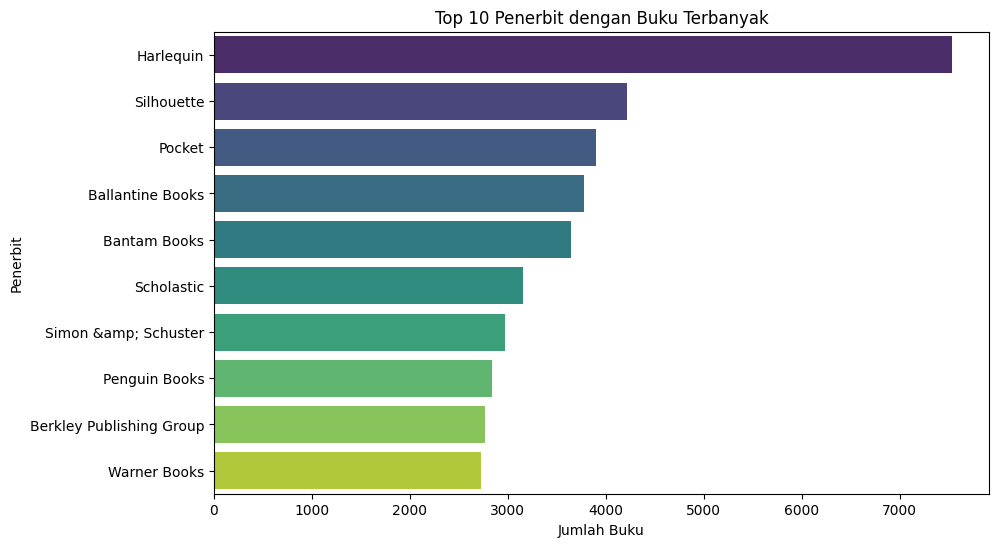

In [14]:
# Top 10 penerbit dengan buku terbanyak
top_publishers = books['Publisher'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_publishers.index, x=top_publishers.values, palette='viridis')
plt.title('Top 10 Penerbit dengan Buku Terbanyak')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penerbit')
plt.show()

In [15]:
# Top 10 buku paling umum
print("Jumlah judul unik:", books['Book-Title'].nunique())
print("Judul buku paling umum:")
print(books['Book-Title'].value_counts().head(10))

Jumlah judul unik: 242135
Judul buku paling umum:
Book-Title
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
Dracula                           20
Adventures of Huckleberry Finn    20
The Secret Garden                 20
Jane Eyre                         19
The Night Before Christmas        18
Pride and Prejudice               18
Great Expectations                17
Name: count, dtype: int64


<ipython-input-16-cf0c5ea7b8aa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ISBN_Length', data=books, palette='Set2')


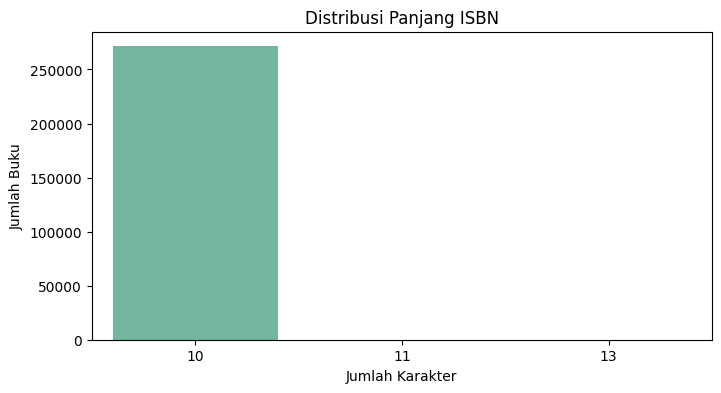

In [16]:
# Distribusi panjang ISBN untuk validasi format
books['ISBN_Length'] = books['ISBN'].astype(str).apply(len)
plt.figure(figsize=(8,4))
sns.countplot(x='ISBN_Length', data=books, palette='Set2')
plt.title('Distribusi Panjang ISBN')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Jumlah Buku')
plt.show()

### Univariate EDA (ratings)


In [17]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [18]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [19]:
print(ratings.isnull().sum())

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [20]:
print(f"Jumlah duplikat User-ID: {ratings['User-ID'].duplicated().sum()}")

Jumlah duplikat User-ID: 1044497


keterangan: User-ID memang muncul berulang kali di dataset rating, karena satu user bisa memberi rating ke banyak buku. Sehingga adanya duplikat itu normal

In [21]:
print(f"Jumlah duplikat baris data: {ratings.duplicated().sum()}")

Jumlah duplikat baris data: 0


<ipython-input-22-35b89ea7836f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


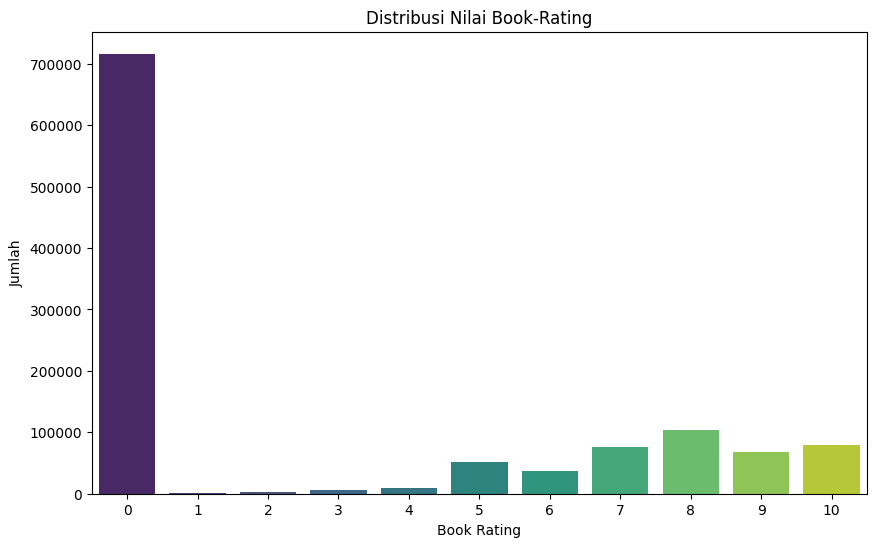

In [22]:
# Frekuensi setiap rating
rating_counts = ratings['Book-Rating'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title('Distribusi Nilai Book-Rating')
plt.xlabel('Book Rating')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

keterangan: Book Rating '0' berarti User-ID mungkin tidak memberikan rating eksplisit. rating tersebut bisa dianggap user pernah berinteraksi dengan buku (hanya melihat) dan bukan penilaian sebenarnya. sehingga nantinya nilai tersebut akan dihilangkan saja dan hanya mengandalkan rating eksplisit (1-10) saja untuk CF dan CBF.

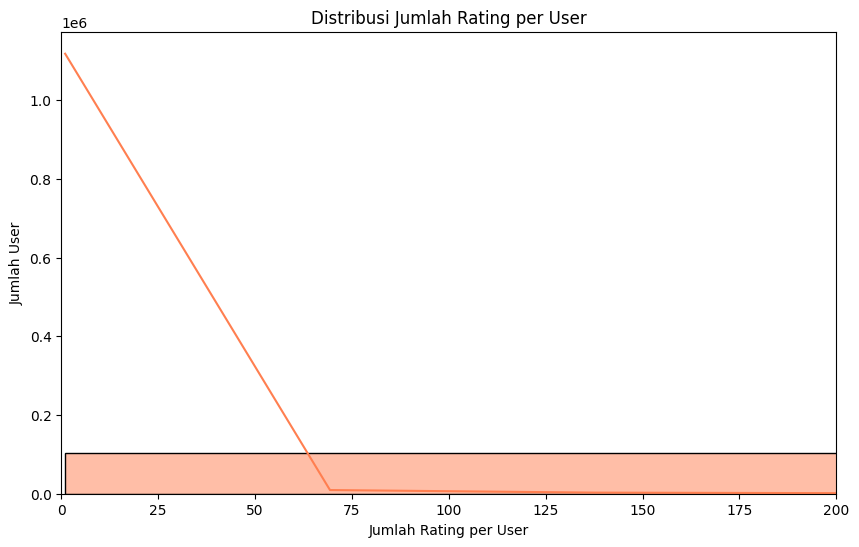

In [23]:
user_rating_counts = ratings['User-ID'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(user_rating_counts, bins=50, kde=True, color='coral')
plt.title('Distribusi Jumlah Rating per User')
plt.xlabel('Jumlah Rating per User')
plt.ylabel('Jumlah User')
plt.xlim(0, 200)
plt.show()

keterangan: banyak user yang hanya memberi sedikit rating sehingga nantinya akan dihapus user yang pasif agar pada saat CF, data tidak menjadi sparse. akibatnya jika pasif (hanya 1-2 rating) maka matriks CF nantinya akan jarang terisi sehingga berpengaruh ke output rekomendasi

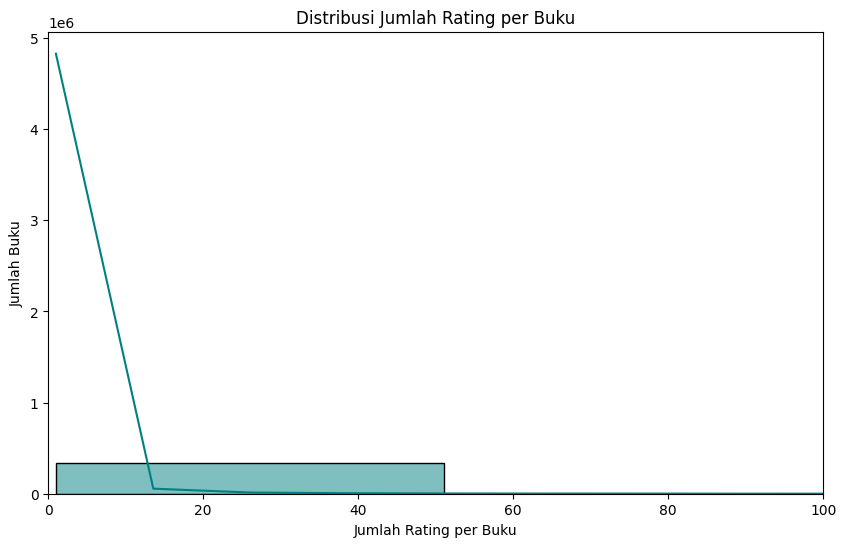

In [24]:
book_rating_counts = ratings['ISBN'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(book_rating_counts, bins=50, kde=True, color='teal')
plt.title('Distribusi Jumlah Rating per Buku')
plt.xlabel('Jumlah Rating per Buku')
plt.ylabel('Jumlah Buku')
plt.xlim(0, 100)
plt.show()

keterangan: banyak buku dengan hanya sedikit rating sehingga untuk CF nanti performa bisa drop karena kurang cukup untuk mengenali kemiripan item/user

<ipython-input-25-dbaf5146c7e5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Book-Rating', data=ratings, palette='coolwarm', showfliers=True)


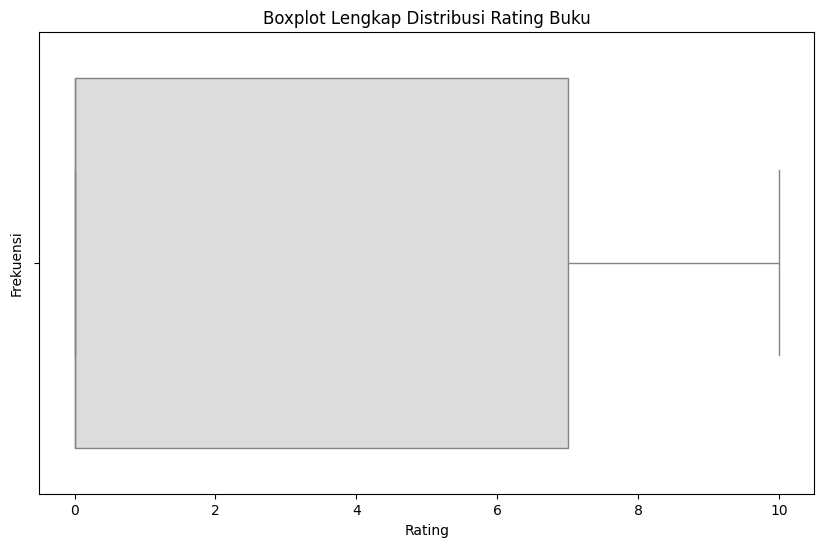

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Book-Rating', data=ratings, palette='coolwarm', showfliers=True)
plt.title('Boxplot Lengkap Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.xticks(rotation=0)
plt.show()

## Data Preparation

In [26]:
# Drop kolom yang tidak relevan
books = books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'ISBN_Length'])

In [27]:
# missing value diubah menjadi 'Unknown'
books['Book-Author'].fillna('Unknown Author', inplace=True)
books['Publisher'].fillna('Unknown Publisher', inplace=True)

<ipython-input-27-e7c3d25d3f80>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books['Book-Author'].fillna('Unknown Author', inplace=True)
<ipython-input-27-e7c3d25d3f80>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [28]:
# Normalisasi teks: hapus spasi ekstra
def clean_text(text):
    if pd.isnull(text):
        return ""

    text = text.strip()                      # hapus spasi di awal/akhir
    text = re.sub(r'\s+', ' ', text)        # hapus spasi berlebih di tengah
    return text

for col in ['Book-Title', 'Book-Author', 'Publisher']:
    books[col] = books[col].apply(clean_text)

In [29]:
books['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

keterangan: 'Year-of-Publication' sengaja tidak diimputasi maupun di drop karena variabel tersebut bukan fokus untuk CF maupun CBF. Sehingga adanya kesalahan input dibiarkan sebagaimana data aslinya.

In [30]:
# Filter user aktif
user_counts = ratings['User-ID'].value_counts()
ratings = ratings[ratings['User-ID'].isin(user_counts[user_counts >= 3].index)]

# Filter buku populer
book_counts = ratings['ISBN'].value_counts()
ratings = ratings[ratings['ISBN'].isin(book_counts[book_counts >= 3].index)]

# Menghilangkan rating 0 (tidak eksplisit)
ratings = ratings[ratings['Book-Rating'] > 0]

In [31]:
# Membuat cf_data dan cbf_data khusus modelling
cf_data = ratings.merge(books[['ISBN',
                               'Book-Title']], on='ISBN', how='left')

cbf_data = ratings.merge(books[['ISBN',
                                'Book-Title',
                                'Book-Author']], on='ISBN', how='left')

In [32]:
cbf_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author
0,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells
1,276747,0671537458,9,Waiting to Exhale,Terry McMillan
2,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks
3,276762,0380711524,5,See Jane Run,Joy Fielding
4,276762,3453092007,8,Die zweite Haut.,Dean Koontz


In [33]:
cbf_data.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,13768
Book-Author,13768


keterangan: Nilai NaN di kolom Book-Title dan Book-Author muncul karena tidak semua ISBN di ratings ada di books sehingga informasi buku tidak lengkap di hasil merge. Untuk kasus content based, adanya nilai NaN akan memengaruhi ketepatan hasil rekomendasi sehingga perlu adanya drop nilai

In [34]:
cbf_data = cbf_data.dropna(subset=['Book-Title', 'Book-Author'])

In [35]:
cbf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253721 entries, 0 to 267488
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      253721 non-null  int64 
 1   ISBN         253721 non-null  object
 2   Book-Rating  253721 non-null  int64 
 3   Book-Title   253721 non-null  object
 4   Book-Author  253721 non-null  object
dtypes: int64(2), object(3)
memory usage: 11.6+ MB


In [36]:
cf_data.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276747,0060517794,9,Little Altars Everywhere
1,276747,0671537458,9,Waiting to Exhale
2,276747,0679776818,8,Birdsong: A Novel of Love and War
3,276762,0380711524,5,See Jane Run
4,276762,3453092007,8,Die zweite Haut.


In [37]:
cf_data.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,13768


keterangan: sama seperti kasus pada cbf_data, tetapi pada kasus ini, 'Book-Title' yang kosong dibiarkan saja karena tidak digunakan dalam CF

### Data Preparation (CBF)

In [38]:
cbf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253721 entries, 0 to 267488
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      253721 non-null  int64 
 1   ISBN         253721 non-null  object
 2   Book-Rating  253721 non-null  int64 
 3   Book-Title   253721 non-null  object
 4   Book-Author  253721 non-null  object
dtypes: int64(2), object(3)
memory usage: 11.6+ MB


In [39]:
# Menampilkan jumlah judul buku yang duplikat
duplicate_titles = cbf_data['Book-Title'].duplicated().sum()
print(f"Jumlah duplikat Book-Title: {duplicate_titles}")

Jumlah duplikat Book-Title: 201475


keterangan: hal tersebut bisa terjadi apabila buku dibaca > 1 user, ISBN beda tadi judul sama, atau adanya variasi penulis dan publisher untuk judul yang sama

keterangan: untuk mencegah google colab crash, maka hanya digunakan beberapa baris data saja agar tidak menghasilkan matrix yang sangat besar. namun, model CBF tetap dapat berjalan dengan dampak menurunnya nilai similarity karena ada buku buku yang mungkin tidak termasuk dalam data sample.

In [40]:
# Diambil 5000 data yang unik saja
cbf_data_sample = cbf_data.drop_duplicates(subset='Book-Title').head(5000).reset_index(drop=True)


In [41]:
# Mmebuat fitur gabungan
cbf_data_sample['content'] = (
    cbf_data_sample['Book-Title'].fillna('') + ' ' +
    cbf_data_sample['Book-Author'].fillna('')
).str.lower()

In [42]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(cbf_data_sample['content'])

In [43]:
# Hitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

### Data Preparation (CF)

In [44]:
cf_data_original = cf_data.copy() # Menyalin dataset asli agar tetap utuh

# Encoding User-ID dan ISBN
user_ids = cf_data['User-ID'].unique().tolist() # mengambil daftar unik variabel
isbn_ids = cf_data['ISBN'].unique().tolist()

# mapping dari variabel asli ke ID numerik urut
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_ids)}
user_encoded_to_user = {i: x for x, i in user_to_user_encoded.items()}
isbn_encoded_to_isbn = {i: x for x, i in isbn_to_isbn_encoded.items()}

# mengganti index dengan hasil encoding (ID numerik)
cf_data['User-ID'] = cf_data['User-ID'].map(user_to_user_encoded)
cf_data['ISBN'] = cf_data['ISBN'].map(isbn_to_isbn_encoded)

num_users = len(user_to_user_encoded)
num_books = len(isbn_to_isbn_encoded)

min_rating = cf_data['Book-Rating'].min()
max_rating = cf_data['Book-Rating'].max()

In [45]:
# Mengacak urutan data untuk memastikan distribusi acak saat training
cf_data = cf_data.sample(frac=1, random_state=42)

# memisahkan fitur x dan y
x = cf_data[['User-ID', 'ISBN']].values
y = cf_data['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values # normalisasi untuk kemudahan saat training

# Menentukan indeks batas untuk split
train_indices = int(0.8 * cf_data.shape[0])

# Membagi data menjadi data latih (train) dan data validasi (val)
x_train, x_val = x[:train_indices], x[train_indices:]
y_train, y_val = y[:train_indices], y[train_indices:]

## Modelling (CBF)

In [46]:
# Membuat mapping
indices = pd.Series(cbf_data_sample.index, index=cbf_data_sample['Book-Title'].str.lower()).drop_duplicates()

def recommend_books_cbf(title, top_n=5):
    # Normalisasi judul agar tidak case-sensitive
    title = title.lower()

    if title not in indices:
        return f"Buku '{title}' tidak ditemukan."

    # Ambil indeks dari buku yang dicari
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort dan ambil top n kecuali dirinya sendiri
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Ambil indeks buku-buku yang paling mirip
    book_indices = [i[0] for i in sim_scores]
    similarities = [round(i[1], 3) for i in sim_scores]

    recommended = cbf_data_sample.iloc[book_indices][['Book-Title', 'Book-Author']].reset_index(drop=True)
    recommended['Similarity'] = similarities

    return recommended


In [47]:
# Contoh penggunaan
recommend_books_cbf('See Jane Run')

,Book-Title,Book-Author,Similarity
0,The First Time,Joy Fielding,0.654
1,Run Jane Run,Maureen Tan,0.522
2,Grand Avenue,Joy Fielding,0.489
3,"Lauf, Jane, lauf. Roman.",Joy Fielding,0.436
4,Olivia Joules and the Overactive Imagination (...,Helen Fielding,0.279


keterangan: nilai 'Similarity' akan semakin tinggi apabila variasi atau jumlah sample cbf_data semakin besar. namun, karena keterbatasan google cloud, sehingga hanya 5000 unique value saja yang dapat diolah.

## Modelling (CF)

In [48]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Layer embedding untuk user
        self.user_embedding = layers.Embedding(
            input_dim=num_users,                    # Jumlah user unik
            output_dim=embedding_size,              # Ukuran vektor embedding
            embeddings_initializer='he_normal',     # Inisialisasi bobot
            embeddings_regularizer=keras.regularizers.l2(1e-6)  # Regularisasi L2 untuk mencegah overfitting
        )

        # Bias khusus untuk tiap user
        self.user_bias = layers.Embedding(num_users, 1)

        # Layer embedding untuk book
        self.book_embedding = layers.Embedding(
            input_dim=num_books,                    # Jumlah buku unik
            output_dim=embedding_size,              # Ukuran vektor embedding
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )

        # Bias khusus untuk tiap buku
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        # Mengambil vektor embedding dan bias berdasarkan input user
        user_vector = self.user_embedding(inputs[:, 0])  # inputs[:, 0] adalah user-ID
        user_bias = self.user_bias(inputs[:, 0])

        # Mengambil vektor embedding dan bias berdasarkan input buku
        book_vector = self.book_embedding(inputs[:, 1])  # inputs[:, 1] adalah book-ID
        book_bias = self.book_bias(inputs[:, 1])

        # Menghitung dot product antara vektor user dan book (interaksi)
        dot_user_book = tf.reduce_sum(user_vector * book_vector, axis=1, keepdims=True)

        # Menambahkan bias user dan bias book ke hasil dot product
        x = dot_user_book + user_bias + book_bias

        # Menggunakan sigmoid agar output berada pada rentang [0, 1]
        return tf.nn.sigmoid(tf.squeeze(x, axis=1))


In [49]:
model = RecommenderNet(num_users, num_books, embedding_size=50)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [50]:
# Callback untuk menghentikan training saat model mulai overfitting
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [51]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0872 - root_mean_squared_error: 0.2945 - val_loss: 0.0622 - val_root_mean_squared_error: 0.2449
Epoch 2/100
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0552 - root_mean_squared_error: 0.2282 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2169
Epoch 3/100
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0433 - root_mean_squared_error: 0.1981 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2049
Epoch 4/100
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0365 - root_mean_squared_error: 0.1829 - val_loss: 0.0411 - val_root_mean_squared_error: 0.1975
Epoch 5/100
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0322 - root_mean_squared_error: 0.1737 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1922
Epoch 6/100
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0289 - root_mean_squared_error: 0.1654 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1887
Epoch 7/100
3344/3344 ━━━━━━

In [52]:
# Ambil 1 user acak dari data encoded
user_id = cf_data['User-ID'].sample(1).iloc[0]
books_read_by_user = cf_data[cf_data['User-ID'] == user_id] # mencari buku yang sudah dibaca user

# Cari buku yang belum dibaca user (encoded)
book_not_read = [x for x in range(num_books) if x not in books_read_by_user['ISBN'].values]
book_not_read = [[x] for x in book_not_read]
user_book_array = np.hstack(([[user_id]] * len(book_not_read), book_not_read))

# Prediksi rating buku yang belum dibaca
ratings = model.predict(user_book_array, verbose=0).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]

In [53]:
# Mendapatkan ISBN asli dari indeks encoded
recommended_book_ids = [
    isbn_encoded_to_isbn[book_not_read[i][0]] for i in top_ratings_indices
]

print(f"Rekomendasi untuk User-ID: {user_encoded_to_user[user_id]}")
print("=" * 30)

# Buku yang disukai user (Top 5 tertinggi dari rating user sebelumnya)
print("Buku yang disukai user:")
top_books_user = books_read_by_user.sort_values(by='Book-Rating', ascending=False).head(5)

for i in top_books_user['ISBN']:
    isbn_asli = isbn_encoded_to_isbn[i]  # konversi lagi ke ISBN asli
    matching_books = cf_data_original[cf_data_original['ISBN'] == isbn_asli]['Book-Title'].values
    if len(matching_books) > 0:
        print("-", matching_books[0])
    else:
        print("-", f"Judul tidak ditemukan untuk ISBN: {isbn_asli}")

# Top 5 Rekomendasi dari model
print("\nTop 5 Rekomendasi Buku:")
for isbn in recommended_book_ids:
    matching_books = cf_data_original[cf_data_original['ISBN'] == isbn]['Book-Title'].values
    if len(matching_books) > 0:
        print("-", matching_books[0])
    else:
        print("-", f"Judul tidak ditemukan untuk ISBN: {isbn}")


Rekomendasi untuk User-ID: 146778
Buku yang disukai user:
- The Secret Life of Bees
- Maiden Voyage
- The Lovely Bones: A Novel
- Couplehood
- nan

Top 5 Rekomendasi Buku:
- Harry Potter and the Chamber of Secrets Postcard Book
- The Return of the King (The Lord of the Rings, Part 3)
- My Sister's Keeper : A Novel (Picoult, Jodi)
- 84 Charing Cross Road
- The Two Towers (The Lord of the Rings, Part 2)


## Evaluation (CBF)

In [54]:
# Metrik evaluasi (Precision) untuk model CBF
def evaluate_cbf_precision(anchor_title, liked_books, top_n=5):
    recommendations = recommend_books_cbf(anchor_title, top_n=top_n)

    # Ambil daftar judul hasil rekomendasi
    recommended_titles = recommendations['Book-Title'].str.lower().tolist()
    liked_books_normalized = [book.lower() for book in liked_books] # list buku yang mungkin disukai user

    # Hitung jumlah rekomendasi yang juga ada di liked_books
    relevant = sum(1 for book in recommended_titles if book in liked_books_normalized)

    # Hitung precision
    precision = relevant / top_n

    print("Anchor Book:", anchor_title)
    print("Recommended Books:", recommended_titles)
    print(f"Precision@{top_n}: {precision:.2f}")

    return precision

In [55]:
# Penggunaan fungsi evaluasi
anchor_title = 'See Jane Run'

liked_books = [
    'The First Time',
    'Run Jane Run',
    'Grand Avenue',
    'Lauf, Jane, lauf. Roman.',
    'Olivia Joules and the Overactive Imagination'
]

evaluate_cbf_precision(anchor_title, liked_books, top_n=5)

Anchor Book: See Jane Run
Recommended Books: ['the first time', 'run jane run', 'grand avenue', 'lauf, jane, lauf. roman.', 'olivia joules and the overactive imagination (fielding, helen)']
Precision@5: 0.80


0.8

## Evaluation (CF)

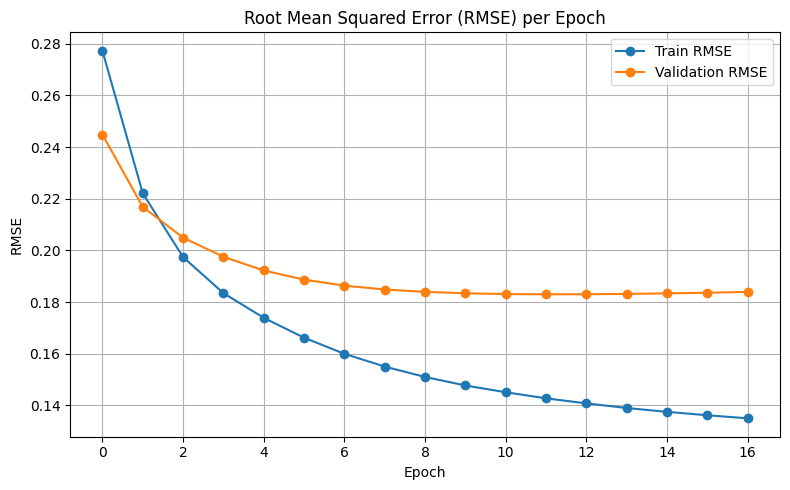

In [56]:
# Visualisasi metrik RMSE selama proses training
plt.figure(figsize=(8, 5))
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE', marker='o')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE', marker='o')
plt.title('Root Mean Squared Error (RMSE) per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()